In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, load_img
from segment_any_change.inference import partial_inference, infer_on_sample

In [2]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [3]:
img_B = load_img(path_B)
img_A = load_img(path_A)

In [4]:
torch.flip(torch.as_tensor([391., 735.]), dims=(0,))

tensor([735., 391.])

In [36]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=0,
    prompt_type="sample",
    n_prompt=5,
    loc="random",
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-19 17:14:39,986 - INFO ::  build vit_h BiSam


ExperimentParams(model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=0, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='sample', n_prompt=5, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240619_171439', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False, loc='random')


2024-06-19 17:14:45,344 - INFO ::  === v2 ====


PROMPT SAMPLE :  tensor([[674., 530.],
        [551., 426.],
        [285., 446.],
        [630., 243.],
        [466.,  50.]])
BATCH SIZE : 1 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
DTYPE input model torch.float32
Function forward Took 12.8248 seconds
sparse_embeddings: torch.Size([1, 5, 2, 256])
dense_embeddings: torch.Size([1, 5, 256, 64, 64])
--in transformer--
src : torch.Size([2, 5, 256, 64, 64])
pos_src : torch.Size([2, 5, 256, 64, 64])
tokens : torch.Size([1, 5, 7, 256])


2024-06-19 17:14:58,430 - INFO ::  Function generate Took 13.0846 seconds
2024-06-19 17:14:58,493 - INFO ::  Function temporal_matching_torch Took 0.0609 seconds


Function predict_masks_batch Took 0.2487 seconds
OUT MODEL : torch.Size([2, 5, 3, 256, 256])
:: raw masks : 15 ::
 filter iou_th : 11
 filter stability_score : 3
 filter mask_threshold : 3
ATTACH 2 masks
:: raw masks : 15 ::
 filter iou_th : 7
 filter stability_score : 7
 filter mask_threshold : 7
ATTACH 7 masks


2024-06-19 17:14:58,626 - INFO ::  Function temporal_matching_torch Took 0.1323 seconds
2024-06-19 17:14:58,629 - INFO ::  Function proposal_matching_nms Took 0.0005 seconds
2024-06-19 17:14:58,639 - INFO ::  Function run Took 13.2934 seconds


NMS masks fusion
masks torch.Size([2, 7, 256, 256])
masks i A torch.Size([2, 256, 256])
masks i B torch.Size([7, 256, 256])
ci torch.Size([2, 7])
bboxes torch.Size([2, 7, 4])
ious torch.Size([2, 7])
masks_logits torch.Size([2, 7, 256, 256])


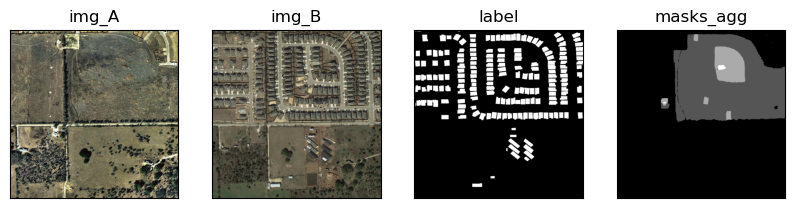

In [37]:
show_prediction_sample(output)

In [38]:
output.keys()

dict_keys(['pred', 'batch'])

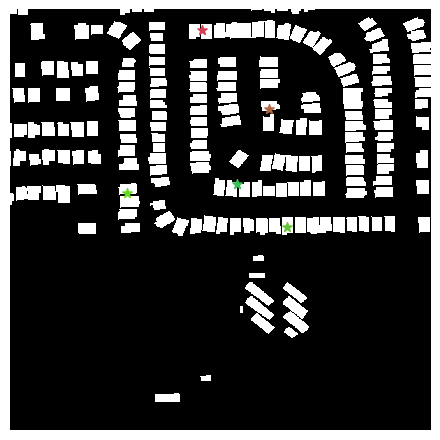

In [39]:
show_img(to_numpy(output["batch"]["label"].squeeze(0) > 0, transpose=False))
ax = plt.gca()

res = output["batch"]["point_coords"].squeeze(0)

color = [np.random.choice(range(256), size=3) / 256 for _ in range(len(res))]

pts = to_numpy(res,transpose=False)
for pt, co in zip(pts, color):
    ax.scatter(*pt, c=[co], marker='*', s=50)

* biais : pour les petits object, le points ont tendances à être samplés sur le bord
* forte variablité de résultats via pred_iou_thresh & pred_iou_thresh => préférer l'exhaustivitée des résultats.
* demander à l'auteur les paramètres utilisés.